# Model Training: 
### Part 1 >>> Predictions at the beginning of the race, no data given during the race is used.

Here we see how close we can predict a race outcome with just data from the Ergast API



In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExajJ0cHhpdnV3NmhpcThscjJ6c3lmd2xvdTVibHluY3hxMDhzZ3lxdiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/SXxMF5CMWWKZUkBBgJ/giphy.gif")

### 1) Importing Packages and Data

In [2]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV #cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

np.random.seed(1994)
pd.set_option('display.max_columns', None)
plt.figure(dpi=150)

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [3]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")

### 2) Data Preprocessing

In [4]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features
#   - null handling

ResultsDF=F1_Preprocessing.preprocess_F1results(ResultsDF,OneHotEncoder=True,HandleNulls=True)

In [5]:
# Group features for further analysis:
selected_features_circuit_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("circuit.circuitid_")].columns.to_list()
selected_features_constructor_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_driver_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("driverid_")].columns.to_list()
selected_features_status_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("final_status_grouped_")].columns.to_list()
selected_features_general=[col for col in ResultsDF.columns if col not in selected_features_circuit_focused+
                           selected_features_constructor_focused+selected_features_driver_focused+selected_features_status_focused]

# Not all the features in these dataframe are available before hand. 
# Below we remove features we don't know before the race starts (apart from dependent variables).
# Here we add features to each observation to have a view of what happened the races before to the same driver
features_to_add_from_the_past=['driverid',"season-round",'final_position', 'final_points','final_grid', 
                               'final_laps','race_time.millis','fastestlap.rank', 'fastestlap.lap',
                               'fastestlap.averagespeed.speed', 'fastestlap.time.in_milliseconds','race_time_millis_to_max',
                               'race_time_millis_to_min', 'race_time_millis_to_avg']

features_to_add_from_the_past+=selected_features_circuit_focused+selected_features_constructor_focused+selected_features_status_focused

print(len(features_to_add_from_the_past))

# Add certain features to see how the driver performed in previous races
ResultsDF2=F1_Preprocessing.get_past_rows(DF=ResultsDF,
                                          N=12,
                                          iterator_feature='driverid',
                                          grouper_feature='season-round',
                                          features_added=features_to_add_from_the_past)


97


In [6]:
#Features to remove (not available during the race, text, already encoded features)
features_to_remove=['driver_number', 'final_positionText', 'final_points','final_laps','driver.givenname', 'driver.familyname',
       'driver.dateofbirth', 'driver.nationality', 'constructor.url','constructor.name', 'constructor.nationality',
       'fastestlap.rank', 'fastestlap.lap', 'fastestlap.time.time','fastestlap.averagespeed.speed','racename',
       'circuit.circuitname', 'circuit.location.country', 'date','fastestlap.time.in_milliseconds',
       'season-round-driverid','race_time_millis_max_round_season','race_time_millis_min_round_season',
       'race_time_millis_avg_round_season', 'race_time_millis_to_max','race_time_millis_to_min', 'race_time_millis_to_avg']
features_to_remove=features_to_remove+selected_features_status_focused

ResultsDF2=ResultsDF2.drop(columns=features_to_remove)



### 3) Check Linear Correlation

This is done to understand if there is any feature that is strong enough in terms of correlation with the dependent features : final position and race time

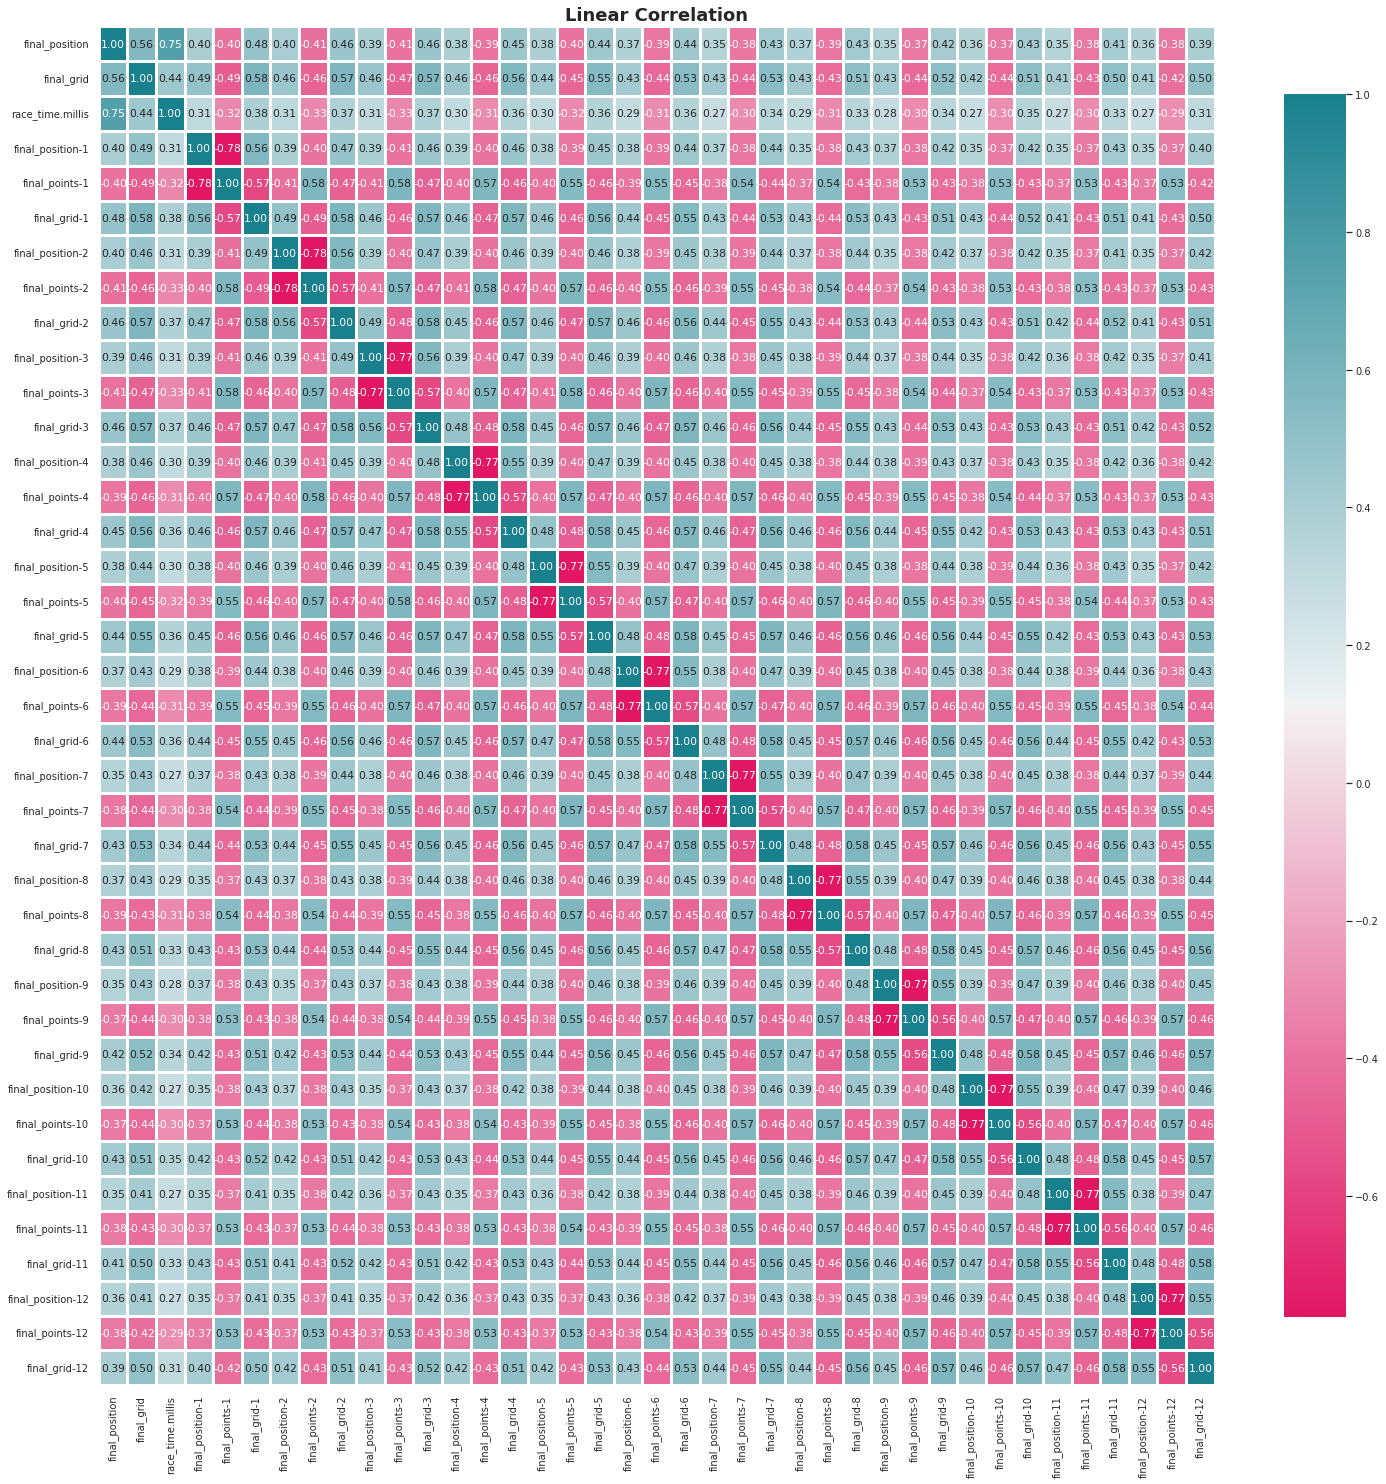

In [7]:

#Create and filter correlation df by absolute correlation value
corr_chosen=0.35
df_corr=ResultsDF2[ResultsDF2.columns].corr()
# high_corr_var=df_corr[(df_corr["race_time.millis"].abs() > corr_chosen)].index
high_corr_var=df_corr[(df_corr["final_position"].abs() > corr_chosen)].index
filtered_corr=df_corr.loc[high_corr_var,high_corr_var]

#Plot df
sns.set_theme(style="whitegrid", font_scale=0.9,font="DejaVu Sans")
fig, axs = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(filtered_corr, annot=True, fmt=".2f", linewidths=3, cmap=cmap,cbar_kws={"shrink": .9},ax=axs)
axs.set_title('Linear Correlation',fontsize=18,fontweight='bold')
plt.show()


### 4) Models

#### A. Random Forest Classifier

In [8]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
TEST_SEGMENTS=[2024] 
TEST_DF=ResultsDF2[ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object'])
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object'])

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET]+["race_time.millis"])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET]+["race_time.millis"])
y_test = TEST_DF[TARGET]

Test DF: 354
Train Validation DF: 7277


In [9]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10],
    # 'min_samples_split': [5,10,15],
    'min_samples_leaf': [10,20,30]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

# Results
print("Best Estimator: ",grid_search.best_estimator_)
print("Best Score: ",grid_search.best_score_)
cv_results = pd.DataFrame(grid_search.cv_results_)
best_model = grid_search.best_estimator_

# Feature importance for top 15 features of best model
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  
DF_importances=pd.DataFrame({"Features":np.array(X.columns)[indices],"Feature Importance":importances[indices]})

fig, axs= plt.subplots(figsize=(8, 6))
sns.barplot(x="Feature Importance", y="Features", data=DF_importances, ax=axs)
axs.set_title("Feature Importance",fontsize=15,fontweight="bold")
plt.show()

Accuracy:  0.1440677966101695
F1 Score:  0.11738858635259633


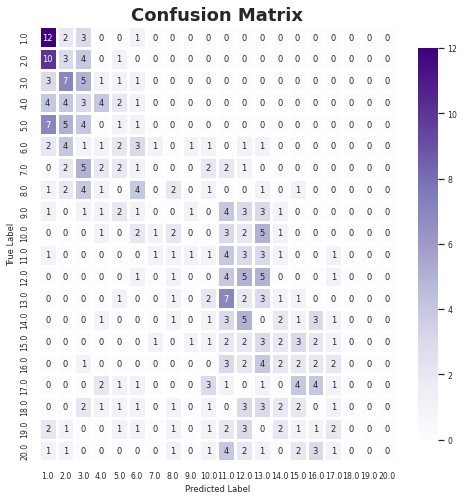

              precision    recall  f1-score   support

         1.0       0.27      0.67      0.39        18
         2.0       0.10      0.17      0.12        18
         3.0       0.15      0.28      0.20        18
         4.0       0.27      0.22      0.24        18
         5.0       0.07      0.06      0.06        18
         6.0       0.16      0.17      0.16        18
         7.0       0.00      0.00      0.00        17
         8.0       0.18      0.12      0.14        17
         9.0       0.25      0.06      0.09        18
        10.0       0.00      0.00      0.00        17
        11.0       0.10      0.24      0.14        17
        12.0       0.15      0.29      0.20        17
        13.0       0.09      0.17      0.12        18
        14.0       0.14      0.11      0.12        18
        15.0       0.18      0.17      0.17        18
        16.0       0.13      0.11      0.12        18
        17.0       0.09      0.06      0.07        18
        18.0       0.00    

c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [10]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set_theme(style="whitegrid", font_scale=0.7,font="DejaVu Sans")
fig, axs = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=3, cmap='Purples', 
           cbar_kws={"shrink": .9},xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),ax=axs)

axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')
axs.set_title('Confusion Matrix',fontsize=18,fontweight='bold')
plt.show()


# Classification report to see accuracy by class
print(classification_report(y_test, y_pred))